# Stock Trading Using Deep Q-Learning

**Problem Statement** <br>
Prepare an agent by implementing Deep Q-Learning that can perform unsupervised trading in stock trade. The aim of this project is to train an agent that uses Q-learning and neural networks to predict the profit or loss by building a model and implementing it on a dataset that is available for evaluation.

The stock trading index environment provides the agent with a set of actions:

Buy <br>
Sell <br>
Do Nothing <br>
<br>
<br>
This project has following sections:

Import libraries <br>
Create a DQN agent <br>
Preprocess the data <br>
Train and build the model <br>
Evaluate the model and agent <br>

<br>

**Steps to perform**

In the section create a DQN agent, create a class called agent where:

Action size is defined as 3. <br>
Experience replay memory to deque is 1000. <br>
Empty list for stocks that has already been bought. <br>
The agent must possess the following hyperparameters: <br>
- gamma= 0.95
-epsilon = 1.0
-epsilon_final = 0.01
-epsilon_decay = 0.995 <br>


Neural network has 3 hidden layers <br>
Action and experience replay are defined <br>

# Solution

### **Import the libraries**

In [1]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
import numpy as np
import random
from collections import deque

#Uncomment this when using this on google colaboratory

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### **Create a DQN agent**

**Instruction to prepare an agent**

* #Action space include 3 actions: Buy, Sell, and Sit
* #Setting up the experience replay memory to deque with 1000 elements inside it
* #Empty list with inventory is created that contains the stocks that were already bought
* #Setting up gamma to 0.95, that helps to maximize the current reward over the long-term
* #Epsilon parameter determines whether to use a random action or to use the model for the action.
* #In the beginning random actions are encouraged, hence epsilon is set up to 1.0 when the model is not trained.
* #And over time the epsilon is reduced to 0.01 in order to decrease the random actions and use the trained model
* #We're then set the speed of decreasing epsililon in the epsilon_decay parameter
*
* #Defining our neural network:
* #Define the neural network function called _model and it just takes the keyword self
* #Define the model with Sequential()
* #Define states i.e. the previous n days and stock prices of the days
* #Defining 3 hidden layers in this network
* #Changing the activation function to relu because mean-squared error is used for the loss

In [3]:
GAMMA=0.95
LEARNING_RATE = 0.001
# memory
MEMORY_SIZE = 1000

# E-Greedy Stratergy
EPSILON_MAX=1.0
EPSILON_MIN=0.01
EPSILON_DECAY=0.995

In [4]:
class Agent:
    def __init__(self,window_size,is_eval=False,model_name=""):
        self.state_size = window_size
        self.epsilon_max = EPSILON_MAX
        self.action_size = 3 #Buy,Sell,Sit
        self.memory=deque(maxlen=MEMORY_SIZE)
        self.inventory=[]
        self.model= load_model("" + model_name) if is_eval else self._model()

    def _model(self):
        model=Sequential()
        model.add(Dense(64, input_shape=(window_size,), activation="relu"))
        model.add(Dense(32, activation="relu"))
        model.add(Dense(8, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(learning_rate=LEARNING_RATE))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state,action, reward, next_state, done))

    def act(self,state):
        if np.random.rand() <= self.epsilon_max:
            return random.randrange(self.action_size)

        #Exploitation
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def expReplay(self,batch_size):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size) #To avoid bias
        for state, action, reward, state_next, terminal in batch:
            q_update = reward
            if not terminal:
                q_update = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))

            q_values = self.model.predict(state)
            q_values[0][action] = q_update
            self.model.fit(state, q_values, verbose=0)

            self.epsilon_max *= EPSILON_DECAY
            self.epsilon_max = max(EPSILON_MIN, self.epsilon_max)



### **Preprocess the stock market data**

In [5]:
import math

# prints formatted price
def formatPrice(n):
	return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# returns the vector containing stock data from a fixed file
def getStockDataVec(key):
	vec = []
	# change path of dataset accordingly
	lines = open("/gspc_dataset/" + key + ".csv", "r").read().splitlines()

	for line in lines[1:]:
		vec.append(float(line.split(",")[4]))

	return vec

# returns the sigmoid
def sigmoid(x):
	return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t
# n is the window_size
def getState(data, t, n):
	d = t - n + 1
	block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
	res = []
	for i in range(n - 1):
		res.append(sigmoid(block[i + 1] - block[i]))

	return np.array([res])

### **Train and build the model**

In [ ]:
import sys

stock_name="^GSPC_2014"
window_size = 10
episode_count = 10

stock_name = str(stock_name)
window_size = int(window_size)
episode_count = int(episode_count)

agent = Agent(window_size)
data = getStockDataVec(stock_name)
l = len(data) - 2
batch_size = 32

for e in range(episode_count + 1):
	print ("Episode " + str(e) + "/" + str(episode_count))
	state = getState(data, 0, window_size + 1)

	total_profit = 0
	agent.inventory = []

	for t in range(l):
		action = agent.act(state)

		# sit
		next_state = getState(data, t + 1, window_size + 1)
		reward = 0

		if action == 1: # buy
			agent.inventory.append(data[t])
			#print ("Buy: " + formatPrice(data[t]))

		elif action == 2 and len(agent.inventory) > 0: # sell
			bought_price = agent.inventory.pop(0)
			reward = max(data[t] - bought_price, 0)
			total_profit += data[t] - bought_price
			#print ("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

		# else do nothing

		done = True if t == l - 1 else False
		agent.memory.append((state, action, reward, next_state, done))
		state = next_state

		if done:
			print ("--------------------------------")
			print ("Total Profit: " + formatPrice(total_profit))

		# experience replay i.e. training
		if len(agent.memory) > batch_size:
			agent.expReplay(batch_size)


		#change path of model accordingly

	# if e % 5 == 0:       #saving every episode in case we can process after an error from last episode
		agent.model.save("/model_weights/model_ep" + str(e)+".h5")

### **Evaluate the model and agent**

In [6]:
import sys
from keras.models import load_model


#Enter stock_name = GSPC_Evaluation_Dataset
#Model_name = respective model name

stock_name="^GSPC_2016"
model_name="/model_weights/model_ep5.h5"
#change path of model accordingly

model = load_model("" + model_name)
window_size = model.layers[0].input.shape.as_list()[1]

agent = Agent(window_size, True, model_name)
data = getStockDataVec(stock_name)
l = len(data) - 1
batch_size = 32

state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory = []
profit=[]
for t in range(l):
	action = agent.act(state)

	# sit
	next_state = getState(data, t + 1, window_size + 1)
	reward = 0
	flag=True
	if action == 1: # buy
		agent.inventory.append(data[t])
		print ("Buy: " + formatPrice(data[t]))

	elif action == 2 and len(agent.inventory) > 0: # sell
		bought_price = agent.inventory.pop(0)
		reward = max(data[t] - bought_price, 0)
		total_profit += data[t] - bought_price
		print ("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
		profit.append(data[t] - bought_price)
		flag=False

	if flag:
		profit.append(0)

	done = True if t == l - 1 else False
	agent.memory.append((state, action, reward, next_state, done))
	state = next_state

	if done:
		print ("--------------------------------")
		print (stock_name + " Total Profit: " + formatPrice(total_profit))



Buy: $2012.66
Sell: $2016.71 | Profit: $4.05
Buy: $1922.03
Sell: $1923.67 | Profit: $1.64
Buy: $1906.90
Sell: $1903.63 | Profit: -$3.27
Buy: $1882.95
Buy: $1939.38
Buy: $1903.03
Buy: $1912.53
Buy: $1915.45
Buy: $1880.05
Buy: $1864.78
Sell: $1895.58 | Profit: $12.63
Buy: $1926.82
Buy: $1917.83
Sell: $1945.50 | Profit: $6.12
Buy: $1929.80
Sell: $1951.70 | Profit: $48.67
Sell: $1948.05 | Profit: $35.52
Buy: $1932.23
Sell: $1978.35 | Profit: $62.90
Sell: $1986.45 | Profit: $106.40
Buy: $1993.40
Buy: $2001.76
Buy: $1979.26
Buy: $1989.26
Buy: $1989.57
Sell: $2022.19 | Profit: $157.41
Buy: $2015.93
Sell: $2027.22 | Profit: $100.40
Buy: $2049.58
Buy: $2049.80
Buy: $2036.71
Buy: $2037.05
Sell: $2063.95 | Profit: $146.12
Buy: $2059.74
Buy: $2072.78
Buy: $2066.66
Sell: $2041.91 | Profit: $112.11
Buy: $2047.60
Sell: $2041.99 | Profit: $109.76
Buy: $2061.72
Buy: $2082.78
Buy: $2080.73
Buy: $2100.80
Buy: $2102.40
Buy: $2091.48
Buy: $2075.81
Buy: $2065.30
Sell: $2063.37 | Profit: $69.97
Sell: $2058.6

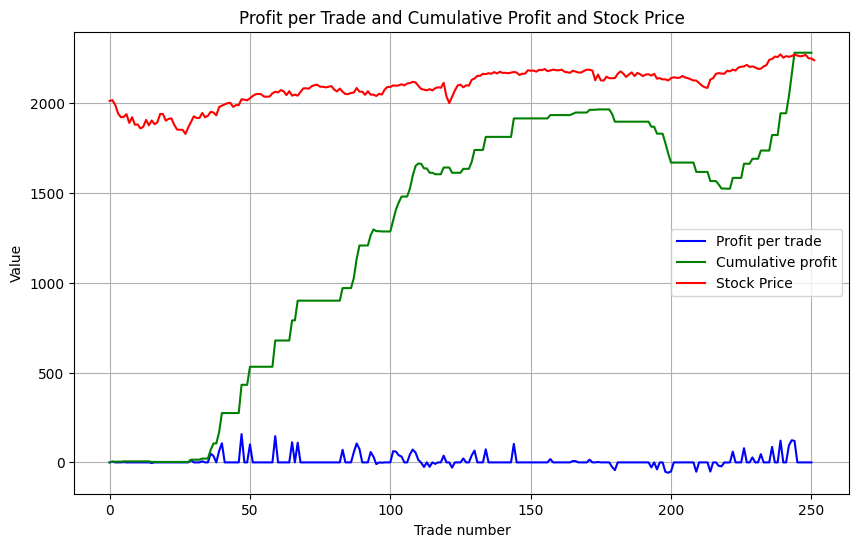

In [7]:
import matplotlib.pyplot as plt

# Calculating cumulative profit
cumulative_profit = [sum(profit[:i+1]) for i in range(len(profit))]

# Plotting profit and cumulative profit in the same figure with different colors
plt.figure(figsize=(12, 4))

# Plotting profit per trade in blue color
plt.plot(profit, label='Profit per trade', color='blue')

# Plotting cumulative profit in green color
plt.plot(cumulative_profit, label='Cumulative profit', color='green')

plt.plot(data, label='Stock Price', color='red')

plt.xlabel('Trade number')
plt.ylabel('Value')
plt.title('Profit per Trade and Cumulative Profit and Stock Price')
plt.legend()
plt.grid(True)
plt.show()


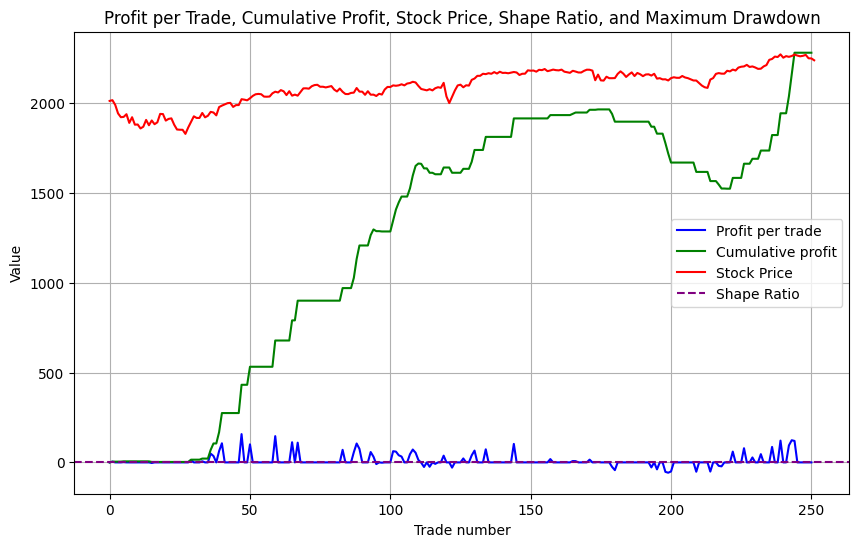

In [8]:
import matplotlib.pyplot as plt

# Calculate sharpe ratio (average profit per trade / standard deviation of profit per trade)
average_profit_per_trade = sum(profit) / len(profit)
std_dev_profit_per_trade = np.std(profit)
sharpe_ratio = average_profit_per_trade / std_dev_profit_per_trade

# Calculate maximum drawdown
max_drawdown = max(cumulative_profit) - min(cumulative_profit)

# Plotting profit, cumulative profit, stock price, shape ratio, and maximum drawdown
plt.figure(figsize=(12, 4))

# Plotting profit per trade in blue color
plt.plot(profit, label='Profit per trade', color='blue')

# Plotting cumulative profit in green color
plt.plot(cumulative_profit, label='Cumulative profit', color='green')

# Plotting stock price in red color
plt.plot(data, label='Stock Price', color='red')

# Plotting shape ratio
plt.axhline(y=sharpe_ratio, color='purple', linestyle='--', label='Shape Ratio')

# Plotting maximum drawdown
# plt.axhline(y=-max_drawdown, color='orange', linestyle='--', label='Maximum Drawdown')

plt.xlabel('Trade number')
plt.ylabel('Value')
plt.title('Profit per Trade, Cumulative Profit, Stock Price, Sharpe Ratio, and Maximum Drawdown')
plt.legend()
plt.grid(True)
plt.show()


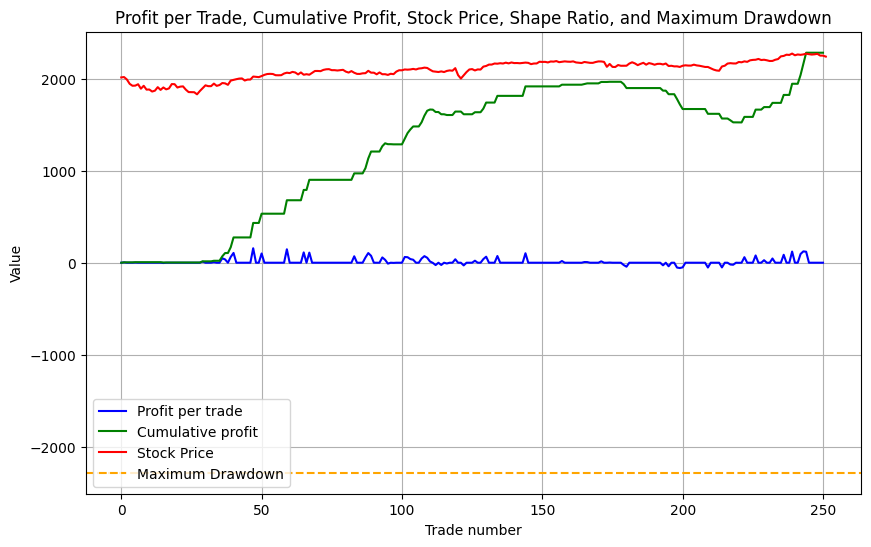

In [10]:
import matplotlib.pyplot as plt

# Calculate shape ratio (average profit per trade / standard deviation of profit per trade)
average_profit_per_trade = sum(profit) / len(profit)
std_dev_profit_per_trade = np.std(profit)
shape_ratio = average_profit_per_trade / std_dev_profit_per_trade

# Calculate maximum drawdown
max_drawdown = max(cumulative_profit) - min(cumulative_profit)

# Plotting profit, cumulative profit, stock price, shape ratio, and maximum drawdown
plt.figure(figsize=(12, 4))

# Plotting profit per trade in blue color
plt.plot(profit, label='Profit per trade', color='blue')

# Plotting cumulative profit in green color
plt.plot(cumulative_profit, label='Cumulative profit', color='green')

# Plotting stock price in red color
plt.plot(data, label='Stock Price', color='red')

# Plotting shape ratio
plt.axhline(y=-max_drawdown, color='orange', linestyle='--', label='Maximum Drawdown')

plt.xlabel('Trade number')
plt.ylabel('Value')
plt.title('Profit per Trade, Cumulative Profit, Stock Price, Shape Ratio, and Maximum Drawdown')
plt.legend()
plt.grid(True)
plt.show()
